# Artist Data Crawling
by : fifi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# InstaMeter
source : https://github.com/kricha/insta_meter <br>
for analyze profile instagram 

In [2]:
from insta_meter import InstaMeter

In [3]:
celine=InstaMeter(username='lauvsongs')  #you can change the username ig what you want
celine.analyze_profile()
celine.print_account_statistic()
celine.print_top_commented()
celine.print_top_liked()

+-- https://instagram.com/lauvsongs/ --------------------------+
|   counter                    |             value             |
+------------------------------+-------------------------------+
|   following                  |              539              |
|   followed                   |            458543             |
|   posts                      |              312              |
|   likes                      |            7356312            |
|   comments                   |            158227             |
|   video views                |            2808547            |
|   likes/post                 |      23577.923076923078       |
|   comments/post              |       507.1378205128205       |
|   views/post                 |       68501.14634146342       |
|                                                              |
+----------- https://github.com/kricha/insta_meter ------------+
+--------------------------------------------------------------+
|                     top

# InstaMeter modification
it is modification of instaMeter to get the some item and then extract to InstagramResult.csv file. <br>
to get some item from multi username, you sould running username what you want one by one.

In [4]:
import _md5
import json
import re
from urllib.parse import quote

import requests

COUNTERS_KEY = 'acc'
COUNT_KEY_FOLLOWING = 'f'  # Following
COUNT_KEY_FOLLOWED_BY = 'fb'  # Followers
COUNT_KEY_POSTS = 'p'  # Posts
COUNT_KEY_VIDEO_POSTS = 'pvp'  # Video posts
COUNT_KEY_IMAGE_POSTS = 'pip'  # Photo posts
COUNT_KEY_ALBUM_POSTS = 'pap'  # Album posts
COUNT_KEY_LIKES = 'lc'  # Likes count key
COUNT_KEY_COMMENTS = 'cc'  # Comments count key
COUNT_KEY_VIDEO_VIEWS = 'vc'  # Video views count key
COUNT_KEY_LIKES_PER_POST = 'lpp'  # Likes per post
COUNT_KEY_COMMENTS_PER_POST = 'cpp'  # Comments per post
COUNT_KEY_VIEWS_PER_POST = 'vpp'  # Video views per post
TOP_PROGRESS = {'lc': 85, 'cc': 90, 'vc': 95}
POST_TYPES_KEYS = {
    'GraphImage': COUNT_KEY_IMAGE_POSTS,
    'GraphVideo': COUNT_KEY_VIDEO_POSTS,
    'GraphSidecar': COUNT_KEY_ALBUM_POSTS,
}


class MultiInstaMeter:
    __profile_fp_url = 'https://instagram.com/{}/?__a=1'
    __profile_rp_url = 'https://instagram.com/graphql/query/?query_hash=42323d64886122307be10013ad2dcc44&variables={}'

    def __init__(self, username, callback=None):
        self.username = username
        self.callback = callback
        self.user = {}
        self.posts = []
        self.__tmp_req_info = None
        self.__tmp_data = []
        self.top_posts_liked = []
        self.top_posts_commented = []
        self.top_posts_viewed = []
        self.__error = None
        self.client = requests.session()
        self.headers = {
            'User-Agent': 'Opera/9.80 (Windows NT 6.1; WOW64; U; en) Presto/2.10.229 Version/11.62',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
            'Accept-Encoding': 'gzip, deflate, br',
            'accept-language': 'ru,en-US;q=0.9,en;q=0.8',
            'Cookie': 'ig_pr=2;',
        }
        self.client.headers.update(self.headers)
        m = re.search(r'"rhx_gis":"([A-z0-9]+)"', self.client.get('https://instagram.com/').text)
        if m is None:
            raise Exception("STOP!")
        self.rhx_gis = m.group(1)

    def analyze_profile(self):
        try:
            self.__get_profile_first_posts()
        except ValueError as exc:
            self.__error = "{}".format(exc)
            self.__use_callback({'success': False, 'error': self.__error})
            return self.__error
        if not self.user['ip'] and self.user[COUNTERS_KEY][COUNT_KEY_POSTS]:
            self.__get_profile_rest_posts()
            self.__send_success_callback('posts_result', self.posts, 60)
            
        if not self.user['ip']:
            self.__send_success_callback('account_result', self.user, 100)

        return json.dumps({
            'account': self.user,
            'posts': self.posts,
            'top_posts_liked': self.top_posts_liked,
            'top_posts_commented': self.top_posts_commented,
            'top_posts_viewed': self.top_posts_viewed,
        }, ensure_ascii=False)

    def __update_instagram_gis(self, params):
        instagram_gis = _md5.md5('{}:{}'.format(self.rhx_gis, params).encode("utf-8")).hexdigest()
        self.client.headers.update({'x-instagram-gis': instagram_gis})

    def __get_profile_first_posts(self):
        url = self.__profile_fp_url.format(self.username)
        self.__update_instagram_gis('/{}/'.format(self.username))
        data = self.client.request('get', url).json()
        user_data = data['graphql']
        self.user['un'] = self.username
        self.user['id'] = user_data['user']['id']
        self.user['fn'] = user_data['user']['full_name']
        self.user['b'] = user_data['user']['biography']
        self.user['pic'] = user_data['user']['profile_pic_url_hd']
        self.user['iv'] = user_data['user']['is_verified']
        self.user['ip'] = user_data['user']['is_private']
        self.user[COUNTERS_KEY] = {
            COUNT_KEY_FOLLOWING: user_data['user']['edge_follow']['count'],
            COUNT_KEY_FOLLOWED_BY: user_data['user']['edge_followed_by']['count'],
            COUNT_KEY_POSTS: user_data['user']['edge_owner_to_timeline_media']['count'],
            COUNT_KEY_IMAGE_POSTS: 0,
            COUNT_KEY_VIDEO_POSTS: 0,
            COUNT_KEY_ALBUM_POSTS: 0,
            COUNT_KEY_LIKES: 0,
            COUNT_KEY_COMMENTS: 0,
            COUNT_KEY_VIDEO_VIEWS: 0,
            COUNT_KEY_LIKES_PER_POST: 0,
            COUNT_KEY_COMMENTS_PER_POST: 0,
            COUNT_KEY_VIEWS_PER_POST: 0,
        }

        self.__send_success_callback('account', self.user)

        if not self.user['ip'] and self.user[COUNTERS_KEY][COUNT_KEY_POSTS]:
            self.__process_posts_first(user_data['user']['edge_owner_to_timeline_media']['edges'])
            self.__tmp_req_info = user_data['user']['edge_owner_to_timeline_media']['page_info']

    def __send_success_callback(self, key, data, progress=None):
        self.__use_callback({'data': {key: data}, '_id': self.user['id'],
                             'progress': progress if progress else self.__calculate_progress(), 'success': True})

    def __use_callback(self, data):
        if callable(self.callback):
            self.callback(data)

    def __process_posts_first(self, posts):
        posts_for_update = []
        for post in posts:
            post = post['node']
            tmp_post = {
                'id': post['id'],
                'd': post['taken_at_timestamp'],
                'code': post['shortcode'],
                'iv': post['is_video'],
            }
            tmp_post.update(self.__update_user_and_post_counters(post))
            posts_for_update.append(tmp_post)
        self.posts.extend(posts_for_update)
        self.__calculate_per_post_counters()
        self.__send_callback_for_post_processing(posts_for_update)

    def __get_profile_rest_posts(self):
        while self.__tmp_req_info['has_next_page']:
            self.__request_for_rest_loop()
            posts_for_update = []
            for post in self.__tmp_data:
                post = post['node']
                tmp_post = {
                    'id': post['id'],
                    'd': post['taken_at_timestamp'],
                    'code': post['shortcode'],
                }
                tmp_post.update(self.__update_user_and_post_counters(post))
                posts_for_update.append(tmp_post)
            self.posts.extend(posts_for_update)
            self.__calculate_per_post_counters()
            self.__send_callback_for_post_processing(posts_for_update)

    def __update_user_and_post_counters(self, post):
        typename = post['__typename']
        comments = post['comments']['count'] if 'comments' in post else post['edge_media_to_comment']['count']
        likes = post['likes']['count'] if 'likes' in post else post['edge_media_preview_like']['count']
        if 'edge_media_to_caption' in post:
            text = post['edge_media_to_caption']['edges'][0]['node']['text'] \
                if post['edge_media_to_caption']['edges'] \
                else ''
        else:
            text = post['caption'] if 'caption' in post else ''
        self.user[COUNTERS_KEY][COUNT_KEY_LIKES] += likes
        self.user[COUNTERS_KEY][COUNT_KEY_COMMENTS] += comments
        self.user[COUNTERS_KEY][POST_TYPES_KEYS[typename]] += 1
        vv_tmp = self.__count_views(post) if post['is_video'] else 0
        return {
            'txt': text,
            COUNT_KEY_LIKES: likes,
            COUNT_KEY_COMMENTS: comments,
            COUNT_KEY_VIDEO_VIEWS: vv_tmp,
            't': POST_TYPES_KEYS[typename],
        }

    @staticmethod
    def __prepare_post_text(text):
        prepared = ' '.join(re.sub(r"(#[\w]+ ?)", '', str(text), flags=re.U).split())[0:99]
        return prepared

    def __calculate_per_post_counters(self):
        posts = float(self.user[COUNTERS_KEY][COUNT_KEY_POSTS])
        ck = COUNTERS_KEY
        if posts:
            self.user[ck][COUNT_KEY_LIKES_PER_POST] = self.user[ck][COUNT_KEY_LIKES] / posts
            self.user[ck][COUNT_KEY_COMMENTS_PER_POST] = self.user[ck][COUNT_KEY_COMMENTS] / posts
            vpc = sum(1 for p in self.posts if p.get('t') == 'pvp')
            self.user[ck][COUNT_KEY_VIEWS_PER_POST] = self.user[ck][COUNT_KEY_VIDEO_VIEWS] / vpc if vpc else 0

    def __request_for_rest_loop(self):
        var_json = {
            'id': self.user['id'],
            'first': 50 if self.user[COUNTERS_KEY][COUNT_KEY_POSTS] > 50 else self.user[COUNTERS_KEY][
                                                                                  COUNT_KEY_POSTS] - 12,
        }
        if self.__tmp_req_info['has_next_page']:
            var_json.update({'after': self.__tmp_req_info['end_cursor']})
        variables = json.dumps(var_json, separators=(',', ':'))
        url = self.__profile_rp_url.format(quote(variables))
        self.__update_instagram_gis(variables)
        data = self.client.request('get', url).json()
        self.__tmp_data = data['data']['user']['edge_owner_to_timeline_media']['edges']
        self.__tmp_req_info = data['data']['user']['edge_owner_to_timeline_media']['page_info']

        return self.__tmp_req_info

    def __send_callback_for_post_processing(self, posts):
        self.__send_success_callback('account', self.user)
        self.__send_success_callback('posts', posts)

    def __count_views(self, post):
        video_views = post.get('video_views', post.get('video_view_count'))
        self.user[COUNTERS_KEY][COUNT_KEY_VIDEO_VIEWS] += video_views
        return video_views

    def __sort_posts(self, key):
        if key == COUNT_KEY_VIDEO_VIEWS:
            tmp_posts = [el for el in self.posts if el['t'] == 'pvp']
        else:
            tmp_posts = list(self.posts)
        tmp_posts.sort(key=lambda post: post[key], reverse=True)
        posts = [post for post in tmp_posts if post[key] > 0][0:12]
        self.__send_success_callback('posts_top_{}'.format(key), posts, TOP_PROGRESS[key])
        return posts

    def __check_user_before_print(self):
        if not self.user:
            print('User was not analyzed because of: "{}"'.format(self.__error))
            exit()

    def print_account_statistic(self):
        self.__check_user_before_print()
        stats = {
            'following': self.user['acc']['f'],
            'followed': self.user['acc']['fb'],
            'posts': self.user[COUNTERS_KEY][COUNT_KEY_POSTS],
            'likes': self.user[COUNTERS_KEY][COUNT_KEY_LIKES],
            'comments': self.user[COUNTERS_KEY][COUNT_KEY_COMMENTS],
            'video views': self.user[COUNTERS_KEY][COUNT_KEY_VIDEO_VIEWS],
            'likes/post': self.user[COUNTERS_KEY][COUNT_KEY_LIKES_PER_POST],
            'comments/post': self.user[COUNTERS_KEY][COUNT_KEY_COMMENTS_PER_POST],
            'views/post': self.user[COUNTERS_KEY][COUNT_KEY_VIEWS_PER_POST],
        }

        with open("Ig.csv", "w") as i:
            a = 'https://instagram.com/'
            b = self.user['un'] + '/'
            i.write(a)
            i.write(b)
            i.write(',')
            for key, value in stats.items():
                i.write(str(value))
                i.write(',')
        with open("Ig.csv", "r") as ii, open("InstagramResult.csv", "a+") as o:
            read = ii.readlines()
            for perbaris in read:
                perbaris = perbaris[:-1]
                o.write(perbaris)
                o.write("\n")

    def __calculate_progress(self):
        has_posts = self.user[COUNTERS_KEY][COUNT_KEY_POSTS]
        if self.user['ip']:
            return 100
        elif has_posts:
            percent = self.posts.__len__() * 100 / float(self.user[COUNTERS_KEY][COUNT_KEY_POSTS])
            return percent if percent < 81 else 80
        else:
            return 100
        

In [5]:
im = MultiInstaMeter(username='shawnmendes') #running username one by one and then it will be add directly in InstagramResult.csv file 
res = im.analyze_profile()
im.print_account_statistic()

instagramresult.csv extract to xlsx 

In [11]:
instagram = pd.read_csv('InstagramResult.csv', names = ["source","following","followed","post","likes","comment","video_views","likes_per_post","comments_per_post","views_per_post"])
writer = pd.ExcelWriter('InstagramResult.xlsx')
instagram.to_excel(writer, index = False)
writer.save()
writer

# Artist databank 

In [7]:
df = pd.read_excel('Artist databank.xlsx', sheetname='yt-ig-fb')

In [8]:
df.head()

,artist,nation,genre1,genre2,youtube_channel,youtube_sub,youtube_videos,youtube_viewer,ig_name,source,...,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
0,Yellow Claw,International,EDM,Hiphop,Yellow Claw,1454203.0,196.0,5.904442e+08,yellowclaw,https://instagram.com/yellowclaw/,...,863191.0,15538944.0,78.934183,9081.562079,105.796176,1904.515749,3164.0,3484.0,1542.0,742880.0
1,Bon Jovi,International,Rock,Rock,Bon Jovi,3680276.0,252.0,2.864696e+07,bonjovi,https://instagram.com/bonjovi/,...,292261.0,7212036.0,13.295655,20206.695279,418.113019,10317.648069,632.0,556.0,632.0,7973210.0
2,NaN,NaN,NaN,NaN,BonJoviVEVO,3022143.0,130.0,3.180666e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANDIEN,Indonesia,Pop,jazz,Andien Aisyah,37320.0,198.0,8.974580e+06,andienaisyah,https://instagram.com/andienaisyah/,...,442215.0,47205454.0,31.363821,7820.389085,70.777049,7555.290333,27.0,62.0,27.0,530810.0
4,Glenn Fredly,Indonesia,Pop,R&B,Glenn Fredly,52414.0,24.0,5.247205e+06,glennfredly309,https://instagram.com/glennfredly309/,...,30330.0,1320124.0,5.723904,3171.594161,44.277372,1927.188321,4135.0,6630.0,2255.0,26930.0


# instagram analysis

In [9]:
ig = pd.read_excel('Artist databank.xlsx', sheetname='ig')

In [10]:
ig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 19 columns):
artist                  67 non-null object
nation                  67 non-null object
genre1                  67 non-null object
genre2                  67 non-null object
ig_name                 67 non-null object
source                  67 non-null object
ig_following            67 non-null int64
ig_follower             67 non-null int64
ig_post                 67 non-null int64
ig_likes                67 non-null int64
ig_comment              67 non-null int64
ig_video_views          67 non-null int64
ig_likes/followe        67 non-null float64
ig_likes_per_post       67 non-null float64
ig_comments_per_post    67 non-null float64
views_per_post          67 non-null float64
ticket sold             67 non-null int64
ticket quota            67 non-null int64
maxticketsold           67 non-null int64
dtypes: float64(4), int64(9), object(6)
memory usage: 10.0+ KB


In [11]:
ig.head()

,artist,nation,genre1,genre2,ig_name,source,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold
0,Yellow Claw,International,EDM,Hiphop,yellowclaw,https://instagram.com/yellowclaw/,3238,938712,8159,74096465,863191,15538944,78.934183,9081.562079,105.796176,1904.515749,3164,3484,1542
1,Bon Jovi,International,Rock,Rock,bonjovi,https://instagram.com/bonjovi/,2018,1062338,699,14124480,292261,7212036,13.295655,20206.695279,418.113019,10317.648069,632,556,632
2,ANDIEN,Indonesia,Pop,jazz,andienaisyah,https://instagram.com/andienaisyah/,2796,1557903,6248,48861791,442215,47205454,31.363821,7820.389085,70.777049,7555.290333,27,62,27
3,Glenn Fredly,Indonesia,Pop,R&B,glennfredly309,https://instagram.com/glennfredly309/,449,379556,685,2172542,30330,1320124,5.723904,3171.594161,44.277372,1927.188321,4135,6630,2255
4,Kla Project,Indonesia,Pop,pop,kla_project,https://instagram.com/kla_project/,49,11571,721,108990,5624,189711,9.419238,151.165049,7.800277,263.122053,168,1850,168


In [12]:
ig.corr()

,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold
ig_following,1.000000,0.251110,0.738359,0.358216,0.496259,0.305974,0.433345,-0.025145,0.036874,-0.021913,-0.168179,-0.223102,-0.192054
ig_follower,0.251110,1.000000,0.258805,0.781880,0.816144,0.847112,0.076426,0.586259,0.544828,0.642637,0.128394,0.058418,0.125771
ig_post,0.738359,0.258805,1.000000,0.425166,0.419587,0.340165,0.632335,-0.006759,-0.010688,-0.040905,-0.010949,-0.026342,-0.083450
ig_likes,0.358216,0.781880,0.425166,1.000000,0.843366,0.791324,0.486215,0.723045,0.591565,0.560346,0.277707,0.244827,0.258730
ig_comment,0.496259,0.816144,0.419587,0.843366,1.000000,0.696723,0.417152,0.629490,0.692292,0.468923,0.189008,0.135993,0.203840
ig_video_views,0.305974,0.847112,0.340165,0.791324,0.696723,1.000000,0.139030,0.545897,0.431009,0.783070,0.092670,0.013342,0.111411
ig_likes/followe,0.433345,0.076426,0.632335,0.486215,0.417152,0.139030,1.000000,0.289881,0.261625,0.028563,0.234608,0.270125,0.205216
ig_likes_per_post,-0.025145,0.586259,-0.006759,0.723045,0.629490,0.545897,0.289881,1.000000,0.927348,0.719846,0.537292,0.434171,0.609777
ig_comments_per_post,0.036874,0.544828,-0.010688,0.591565,0.692292,0.431009,0.261625,0.927348,1.000000,0.614463,0.497550,0.385742,0.590986
views_per_post,-0.021913,0.642637,-0.040905,0.560346,0.468923,0.783070,0.028563,0.719846,0.614463,1.000000,0.280551,0.180118,0.350097


the highest correlation between maxticket sold and likes per post instagram.


In [13]:
np.corrcoef(ig['maxticketsold'],ig['ig_likes_per_post'])

array([[ 1.        ,  0.60977671],
       [ 0.60977671,  1.        ]])

In [14]:
np.corrcoef(ig['ticket sold'],ig['ig_likes_per_post'])

array([[ 1.        ,  0.53729158],
       [ 0.53729158,  1.        ]])

### Linier regression for instagram

In [15]:
from sklearn import linear_model

In [16]:
ig.columns

Index(['artist', 'nation', 'genre1', 'genre2', 'ig_name', 'source',
       'ig_following', 'ig_follower', 'ig_post', 'ig_likes', 'ig_comment',
       'ig_video_views', 'ig_likes/followe', 'ig_likes_per_post',
       'ig_comments_per_post', 'views_per_post', 'ticket sold', 'ticket quota',
       'maxticketsold'],
      dtype='object')

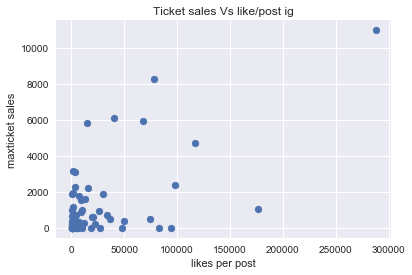

In [17]:
Y_ig=ig['maxticketsold'].values
X_ig=ig['ig_likes_per_post'].values
plt.scatter(X_ig,Y_ig)
plt.xlabel('likes per post')
plt.ylabel('maxticket sales')
plt.title('Ticket sales Vs like/post ig')

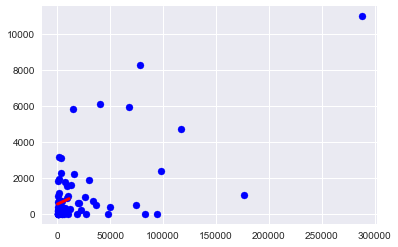

In [18]:
X_ig=X_ig.reshape(-1,1)
Y_ig=Y_ig.reshape(-1,1)
reg_ig = linear_model.LinearRegression(normalize=True)
reg_ig.fit(X_ig,Y_ig)
prediction_ig = np.linspace(min(X_ig),max(Y_ig)).reshape(-1,1)
plt.scatter(X_ig, Y_ig, color='blue')
plt.plot(prediction_ig, reg_ig.predict(prediction_ig),
         color='red', linewidth=3)

In [19]:
prediction_ig

array([[    43.        ],
       [   266.34693878],
       [   489.69387755],
       [   713.04081633],
       [   936.3877551 ],
       [  1159.73469388],
       [  1383.08163265],
       [  1606.42857143],
       [  1829.7755102 ],
       [  2053.12244898],
       [  2276.46938776],
       [  2499.81632653],
       [  2723.16326531],
       [  2946.51020408],
       [  3169.85714286],
       [  3393.20408163],
       [  3616.55102041],
       [  3839.89795918],
       [  4063.24489796],
       [  4286.59183673],
       [  4509.93877551],
       [  4733.28571429],
       [  4956.63265306],
       [  5179.97959184],
       [  5403.32653061],
       [  5626.67346939],
       [  5850.02040816],
       [  6073.36734694],
       [  6296.71428571],
       [  6520.06122449],
       [  6743.40816327],
       [  6966.75510204],
       [  7190.10204082],
       [  7413.44897959],
       [  7636.79591837],
       [  7860.14285714],
       [  8083.48979592],
       [  8306.83673469],
       [  85

In [20]:
reg_ig.coef_

array([[ 0.02710677]])

In [21]:
reg_ig.intercept_

array([ 549.59154126])


### Ticketsales = 549,6 + 0,027 like_per_post
linier regression model

In [22]:
print('R-square from the model is')
print(reg_ig.score(X_ig,Y_ig))
#representation of model ex: score =0.27 it's mean that model represents 27% of ticket sales influenced by like per post

R-square from the model is
0.37182763065


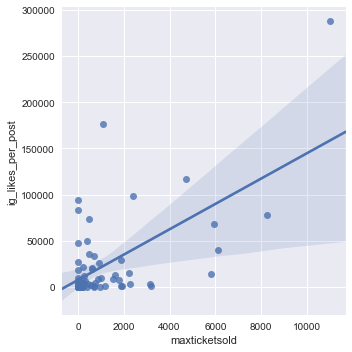

In [23]:
sns.lmplot('maxticketsold','ig_likes_per_post', data=ig)

# youtube analysis
youtube analysis website : socialblade.com

In [24]:
yt = pd.read_excel('Artist databank.xlsx', sheetname='yt')

In [25]:
yt.head()

,artist,nation,genre1,genre2,youtube_channel,youtube_sub,youtube_videos,youtube_viewer,ticket sold,ticket quota,maxticketsold
0,Yellow Claw,International,EDM,Hiphop,Yellow Claw,1454203,196,590444157,3164,3484,1542
1,Bon Jovi,International,Rock,Rock,Bon Jovi,3680276,252,3180665942,632,556,632
2,ANDIEN,Indonesia,Pop,jazz,Andien Aisyah,37320,198,8974580,27,62,27
3,Glenn Fredly,Indonesia,Pop,R&B,Glenn Fredly,52414,24,5247205,4135,6630,2255
4,The Vamps,International,Pop,pop rock,the vamps,3356286,357,603497343,376,4980,376


In [26]:
yt.corr()

,youtube_sub,youtube_videos,youtube_viewer,ticket sold,ticket quota,maxticketsold
youtube_sub,1.000000,0.135282,0.841455,0.273751,0.212644,0.312810
youtube_videos,0.135282,1.000000,0.119449,0.223481,0.344279,0.166633
youtube_viewer,0.841455,0.119449,1.000000,0.276053,0.160642,0.336377
ticket sold,0.273751,0.223481,0.276053,1.000000,0.880378,0.941207
ticket quota,0.212644,0.344279,0.160642,0.880378,1.000000,0.819788
maxticketsold,0.312810,0.166633,0.336377,0.941207,0.819788,1.000000


# Facebook analysis

In [27]:
fb = pd.read_excel('Artist databank.xlsx', sheetname='fb')

In [28]:
fb.head()

,artist,nation,genre1,genre2,ticket sold,ticket quota,maxticketsold,Minat_fb
0,Yellow Claw,International,EDM,Hiphop,3164,3484,1542,742880
1,Bon Jovi,International,Rock,Rock,632,556,632,7973210
2,ANDIEN,Indonesia,Pop,jazz,27,62,27,530810
3,Glenn Fredly,Indonesia,Pop,R&B,4135,6630,2255,26930
4,Dewa,Indonesia,Rock,pop Rock,1170,1824,1170,3679460


In [29]:
fb.corr()

,ticket sold,ticket quota,maxticketsold,Minat_fb
ticket sold,1.000000,0.908943,0.950102,0.481221
ticket quota,0.908943,1.000000,0.836855,0.453337
maxticketsold,0.950102,0.836855,1.000000,0.505798
Minat_fb,0.481221,0.453337,0.505798,1.000000


In [30]:
np.corrcoef(fb['maxticketsold'],fb['Minat_fb'])

array([[ 1.        ,  0.50579821],
       [ 0.50579821,  1.        ]])

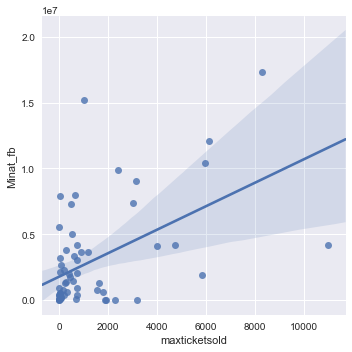

In [31]:
sns.lmplot('maxticketsold','Minat_fb', data=fb)

# Merge facebook and instagram data

In [32]:
yt.columns

Index(['artist', 'nation', 'genre1', 'genre2', 'youtube_channel',
       'youtube_sub', 'youtube_videos', 'youtube_viewer', 'ticket sold',
       'ticket quota', 'maxticketsold'],
      dtype='object')

In [33]:
fb.columns

Index(['artist', 'nation', 'genre1', 'genre2', 'ticket sold', 'ticket quota',
       'maxticketsold', 'Minat_fb'],
      dtype='object')

In [34]:
joinigfb=pd.merge(ig,fb, on=['artist','ticket sold','ticket quota','maxticketsold','nation', 'genre1','genre2' ], how='inner')

In [35]:
joinigfb.columns

Index(['artist', 'nation', 'genre1', 'genre2', 'ig_name', 'source',
       'ig_following', 'ig_follower', 'ig_post', 'ig_likes', 'ig_comment',
       'ig_video_views', 'ig_likes/followe', 'ig_likes_per_post',
       'ig_comments_per_post', 'views_per_post', 'ticket sold', 'ticket quota',
       'maxticketsold', 'Minat_fb'],
      dtype='object')

In [36]:
joinigfb.describe()

,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
count,51.000000,5.100000e+01,51.000000,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01
mean,665.450980,1.980335e+06,1628.058824,3.650751e+07,5.549739e+05,1.879139e+07,18.267795,26223.404894,400.651442,14233.386729,1666.039216,2527.000000,1411.607843,3.151990e+06
std,1041.687886,3.141985e+06,1634.918156,5.506135e+07,9.491043e+05,2.744006e+07,15.490457,47933.973667,800.568469,21968.512081,2720.175112,3217.227452,2318.466382,4.081634e+06
min,0.000000,9.670000e+02,16.000000,2.210000e+03,6.090000e+02,0.000000e+00,2.285419,99.085366,2.846690,0.000000,2.000000,3.000000,2.000000,9.750000e+03
25%,50.000000,1.250420e+05,587.500000,1.752792e+06,3.276900e+04,1.492532e+06,8.686859,1744.667201,42.858598,1631.106292,23.500000,200.000000,23.500000,3.908300e+05
50%,235.000000,5.543080e+05,957.000000,8.890064e+06,1.255620e+05,6.158881e+06,13.584962,7257.572843,116.622312,4660.358471,475.000000,1058.000000,475.000000,1.434390e+06
75%,812.000000,2.710475e+06,2135.000000,4.909214e+07,6.755595e+05,2.331915e+07,20.693762,27666.006296,369.619844,14968.329004,2357.500000,4059.500000,1689.000000,3.989515e+06
max,5354.000000,1.625562e+07,8159.000000,2.162700e+08,4.499267e+06,1.102159e+08,78.934183,287955.395270,5104.263514,91644.285088,11785.000000,14960.000000,10987.000000,1.731431e+07


In [37]:
ig_fb=joinigfb[['ticket sold','ig_likes_per_post','Minat_fb']]

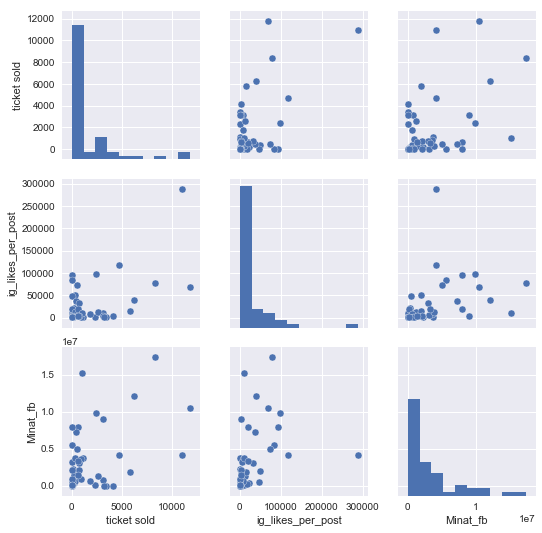

In [38]:
sns.pairplot(ig_fb)

In [39]:
ig_fb.corr()

,ticket sold,ig_likes_per_post,Minat_fb
ticket sold,1.000000,0.580011,0.461296
ig_likes_per_post,0.580011,1.000000,0.376194
Minat_fb,0.461296,0.376194,1.000000


In [40]:
max_ig_fb=joinigfb[['maxticketsold','ig_likes_per_post','Minat_fb']]

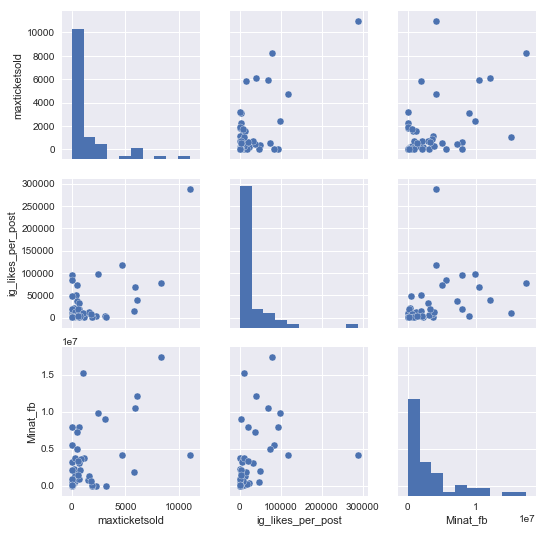

In [41]:
sns.pairplot(max_ig_fb)

In [42]:
max_ig_fb.corr()

,maxticketsold,ig_likes_per_post,Minat_fb
maxticketsold,1.000000,0.661461,0.486360
ig_likes_per_post,0.661461,1.000000,0.376194
Minat_fb,0.486360,0.376194,1.000000


In [43]:
from sklearn.preprocessing import scale
from collections import Counter
enroll_data=max_ig_fb[['ig_likes_per_post','Minat_fb']].values
enroll_target=max_ig_fb['maxticketsold'].values

varX,varY=scale(enroll_data),enroll_target

In [44]:
linreg=linear_model.LinearRegression(normalize=True)
linreg.fit(varX,varY)
print('R-square from the model is')
print(linreg.score(varX,varY))

R-square from the model is
0.503248009535


In [45]:
linreg.coef_

array([ 1279.52635953,   635.14924802])

In [46]:
linreg.intercept_

1411.6078431372548

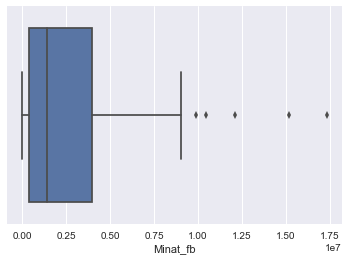

In [47]:
sns.boxplot(max_ig_fb['Minat_fb'])

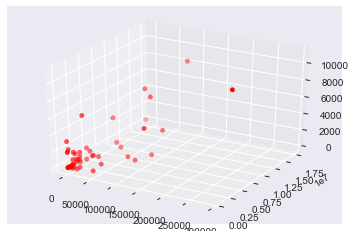

In [48]:
from mpl_toolkits.mplot3d import Axes3D

X1=np.ndarray.tolist(max_ig_fb['ig_likes_per_post'].values)
X2=np.ndarray.tolist(max_ig_fb['Minat_fb'].values)
c= linreg.intercept_
Ymulti=np.ndarray.tolist(max_ig_fb['maxticketsold'].values)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X1,X2,Ymulti, c='r', marker='o')

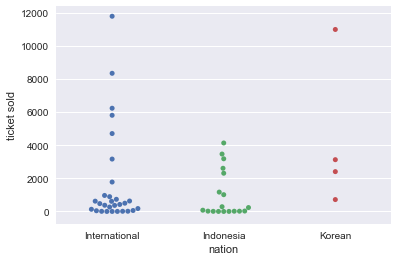

In [49]:
sns.swarmplot(x='nation', y='ticket sold',data=joinigfb)

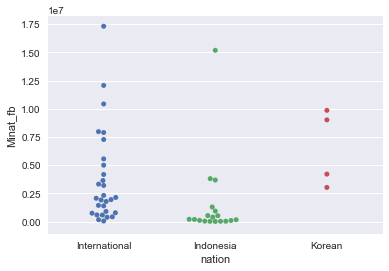

In [50]:
sns.swarmplot(x='nation', y='Minat_fb',data=joinigfb)

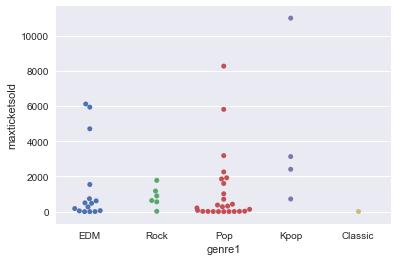

In [52]:
sns.swarmplot(x='genre1', y='maxticketsold',data=joinigfb)

### Filtering by nation

In [90]:
index_indo = joinigfb['nation'] == "Indonesia"
index_inter = joinigfb['nation'] == "International" 
index_korea = joinigfb['nation'] == "Korean"
indo = joinigfb[index_indo]
international = joinigfb[index_inter]
korea = joinigfb[index_korea]
inter =pd.concat([international,korea])

In [91]:
indo.describe()

,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
count,18.000000,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01
mean,645.277778,1.939060e+06,1705.111111,1.883060e+07,4.327350e+05,1.948384e+07,12.405566,8628.716335,194.978629,10966.917314,1032.500000,1628.833333,758.777778,1.512060e+06
std,914.887702,3.907863e+06,1600.465810,3.054059e+07,1.046305e+06,3.053450e+07,7.222185,11795.024597,422.612316,19565.846797,1429.214891,2061.447414,1002.110335,3.602951e+06
min,3.000000,9.124000e+03,343.000000,5.687500e+04,1.436000e+03,5.380900e+04,5.591159,99.085366,2.846690,93.743902,2.000000,29.000000,2.000000,9.750000e+03
25%,23.250000,7.994125e+04,578.250000,8.469852e+05,1.899850e+04,1.328325e+06,6.814152,1028.846643,22.577300,1435.208202,16.250000,161.500000,16.250000,5.481000e+04
50%,208.500000,4.237535e+05,1057.500000,4.660158e+06,7.647950e+04,2.709260e+06,10.383676,4152.212785,57.678612,4275.056265,157.000000,461.500000,141.000000,1.958800e+05
75%,816.000000,1.624410e+06,2372.000000,2.573643e+07,3.907005e+05,3.368279e+07,14.869684,11279.558164,193.260536,9795.880034,2024.250000,2679.250000,1492.500000,8.312525e+05
max,2796.000000,1.625562e+07,6248.000000,1.166208e+08,4.499267e+06,1.102159e+08,31.363821,47815.014350,1844.717917,77102.126538,4135.000000,6630.000000,3181.000000,1.518053e+07


In [92]:
inter.describe()

,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
count,33.000000,3.300000e+01,33.000000,3.300000e+01,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,3.300000e+01
mean,676.454545,2.002848e+06,1586.030303,4.614946e+07,6.216496e+05,1.841369e+07,21.465375,35820.507745,512.836613,16015.097319,2011.606061,3016.909091,1767.696970,4.046498e+06
std,1118.244022,2.703830e+06,1676.467333,6.300764e+07,9.016213e+05,2.609147e+07,17.814146,56983.124548,932.612734,23268.796809,3182.358873,3635.089368,2737.681164,4.098368e+06
min,0.000000,9.670000e+02,16.000000,2.210000e+03,6.090000e+02,0.000000e+00,2.285419,138.125000,8.117199,0.000000,2.000000,3.000000,2.000000,4.880000e+04
25%,61.000000,1.873880e+05,592.000000,2.179963e+06,5.489000e+04,2.145880e+06,10.416153,3032.652174,56.571906,1904.515749,133.000000,300.000000,133.000000,8.986400e+05
50%,241.000000,6.618270e+05,957.000000,1.271086e+07,2.026530e+05,6.621945e+06,15.445862,8863.847387,146.023760,5037.276995,613.000000,1429.000000,558.000000,2.316930e+06
75%,798.000000,2.723774e+06,2040.000000,7.409646e+07,8.631910e+05,2.108960e+07,23.221803,49916.212873,526.812127,18175.535117,2406.000000,4900.000000,1778.000000,5.556860e+06
max,5354.000000,1.044184e+07,8159.000000,2.162700e+08,3.645508e+06,9.255643e+07,78.934183,287955.395270,5104.263514,91644.285088,11785.000000,14960.000000,10987.000000,1.731431e+07


In [95]:
np.corrcoef(inter['ig_likes_per_post'],inter['maxticketsold'])

array([[ 1.        ,  0.68465478],
       [ 0.68465478,  1.        ]])

In [98]:
np.corrcoef(indo['Minat_fb'],indo['maxticketsold'])

array([[ 1.        ,  0.04113066],
       [ 0.04113066,  1.        ]])

In [96]:
inter.corr()

,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
ig_following,1.000000,0.180317,0.750900,0.422131,0.493914,0.420901,0.401760,-0.101186,-0.081905,-0.101993,-0.161238,-0.232008,-0.199742,0.038820
ig_follower,0.180317,1.000000,0.151191,0.746149,0.701674,0.841054,0.067604,0.560425,0.474956,0.660039,0.272898,0.182862,0.246969,0.557176
ig_post,0.750900,0.151191,1.000000,0.475770,0.441113,0.348187,0.723336,-0.115107,-0.126458,-0.184701,-0.021872,-0.027507,-0.120506,-0.066894
ig_likes,0.422131,0.746149,0.475770,1.000000,0.952733,0.763415,0.557499,0.615363,0.552088,0.422362,0.379214,0.359020,0.326405,0.389593
ig_comment,0.493914,0.701674,0.441113,0.952733,1.000000,0.787698,0.500888,0.659528,0.649744,0.480303,0.299961,0.239823,0.306856,0.339870
ig_video_views,0.420901,0.841054,0.348187,0.763415,0.787698,1.000000,0.180200,0.471635,0.435830,0.629170,0.276951,0.175302,0.286235,0.511345
ig_likes/followe,0.401760,0.067604,0.723336,0.557499,0.500888,0.180200,1.000000,0.225267,0.207606,-0.034110,0.183623,0.219634,0.129825,-0.054525
ig_likes_per_post,-0.101186,0.560425,-0.115107,0.615363,0.659528,0.471635,0.225267,1.000000,0.971908,0.799089,0.612500,0.493605,0.684655,0.382137
ig_comments_per_post,-0.081905,0.474956,-0.126458,0.552088,0.649744,0.435830,0.207606,0.971908,1.000000,0.762724,0.550657,0.423352,0.648709,0.308101
views_per_post,-0.101993,0.660039,-0.184701,0.422362,0.480303,0.629170,-0.034110,0.799089,0.762724,1.000000,0.479986,0.342029,0.572038,0.537360


In [105]:
inter.sort_values("ticket sold",ascending=False).head()

,artist,nation,genre1,genre2,ig_name,source,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
12,Hardwell,International,EDM,EDM,hardwell,https://instagram.com/hardwell/,216,5146894,2177,148094764,1146870,32681823,28.773618,68026.993110,526.812127,15012.321084,11785,14960,5933,10425840
41,Wanna One,Korean,Kpop,Kpop,wannaone.official,https://instagram.com/wannaone.official/,0,3755790,592,170469594,3021724,44711854,45.388479,287955.395270,5104.263514,75526.780405,10987,11072,10987,4205750
40,Celine Dion,International,Pop,Pop,celinedion,https://instagram.com/celinedion/,39,2697176,275,21482118,320603,15065318,7.964670,78116.792727,1165.829091,54782.974545,8341,8493,8262,17314310
34,The Chainsmokers,International,EDM,EDM,thechainsmokers,https://instagram.com/thechainsmokers/,826,6948618,2809,113075175,1232897,92556428,16.273045,40254.601282,438.909576,32949.956568,6232,6712,6112,12068790
33,The xx,International,Pop,Pop,thexx,https://instagram.com/thexx/,61,661827,891,12710856,101035,6613811,19.205708,14265.831650,113.395062,7422.907969,5807,6598,5807,1911920


In [106]:
indo.sort_values("ticket sold",ascending=False).head()

,artist,nation,genre1,genre2,ig_name,source,ig_following,ig_follower,ig_post,ig_likes,ig_comment,ig_video_views,ig_likes/followe,ig_likes_per_post,ig_comments_per_post,views_per_post,ticket sold,ticket quota,maxticketsold,Minat_fb
3,Glenn Fredly,Indonesia,Pop,R&B,glennfredly309,https://instagram.com/glennfredly309/,449,379556,685,2172542,30330,1320124,5.723904,3171.594161,44.277372,1927.188321,4135,6630,2255,26930
6,Kahitna,Indonesia,Pop,pop,kahitna,https://instagram.com/kahitna/,9,94838,2697,1884348,66192,2015133,19.869124,698.682981,24.542825,747.175751,3467,5212,1858,28700
47,Yovie and Nuno,Indonesia,Pop,Pop,yovieandnuno,https://instagram.com/yovieandnuno/,4,67046,1374,1361336,30121,774029,20.304507,990.783115,21.922125,563.339884,3181,3225,3181,9750
26,Sheila on 7,Indonesia,Pop,Pop,sheilaon7,https://instagram.com/sheilaon7/,4,467951,557,7158679,116274,5872308,15.297924,12852.206463,208.750449,10542.743268,2608,4491,1600,1291950
7,Maliq & d'essentials,Indonesia,Pop,pop,maliqmusic,https://instagram.com/maliqmusic/,88,78727,1256,1828536,35208,1754958,23.226288,1455.840764,28.031847,1397.259554,2309,2569,1922,41520


### Charlie puth, john mayer, ed sheeran

In [114]:
instagram = pd.read_csv('InstagramResult.csv', names = ["source","following","followed","post","likes","comment","video_views","likes_per_post","comments_per_post","views_per_post"])
writer = pd.ExcelWriter('InstagramResult.xlsx')
instagram.to_excel(writer, index = False)
writer.save()
writer

In [116]:
data3 = pd.read_excel('Artist databank.xlsx', sheetname='shawn mendes')

In [119]:
data3[:4]

,source,following,followed,post,likes,comment,video_views,likes_per_post,comments_per_post,views_per_post,fb interest
0,https://instagram.com/charlieputh/,180.0,11682601,93,66628051,824410.0,27086788.0,716430.655914,8864.623656,1.231218e+06,7156680.0
1,https://instagram.com/edsheerandouble/,135.0,104012,268,718060,9671.0,170057.0,2679.328358,36.085821,1.308131e+04,35408880.0
2,https://instagram.com/johnmayer/,1261.0,3730994,1273,100622894,2351026.0,49392066.0,79043.907306,1846.838963,2.855033e+05,3908140.0
3,https://instagram.com/shawnmendes/,797.0,37850643,2004,1417418546,20755544.0,346335881.0,707294.683633,10357.057884,8.207011e+05,16103820.0


In [129]:
help(data3.add)

Help on method add in module pandas.core.ops:

add(other, axis='columns', level=None, fill_value=None) method of pandas.core.frame.DataFrame instance
    Addition of dataframe and other, element-wise (binary operator `add`).
    
    Equivalent to ``dataframe + other``, but with support to substitute a fill_value for
    missing data in one of the inputs.
    
    Parameters
    ----------
    other : Series, DataFrame, or constant
    axis : {0, 1, 'index', 'columns'}
        For Series input, axis to match Series index on
    fill_value : None or float value, default None
        Fill missing (NaN) values with this value. If both DataFrame
        locations are missing, the result will be missing
    level : int or name
        Broadcast across a level, matching Index values on the
        passed MultiIndex level
    
    Notes
    -----
    Mismatched indices will be unioned together
    
    Returns
    -------
    result : DataFrame
    
    See also
    --------
    DataFrame.rad

# Twitter Scarper
source : https://github.com/taspinar/twitterscraper

In [2]:
import codecs, json

In [3]:
#codes in prompt
#twitterscraper Lauv --limit 100 --output=tweets.json
#twitterscraper "Hardwell AND Indonesia" --output tweets.json --limit 1000

In [4]:
with codecs.open('tweets.json','r','utf-8') as f:
    tweets = json.load(f, encoding = 'utf-8')
list_tweets = [list(elem.values()) for elem in tweets]
list_columns = list(tweets[0].keys())
df_tweet = pd.DataFrame(list_tweets, columns=list_columns)

In [5]:
df_tweet.text

0                      @HARDWELL When come to indonesia?
1      @HARDWELL We'll wait for your DJ school open i...
2      Next : Hardwell.! @anjaanya: Was supeeeer!!! R...
3      Was supeeeer!!! RT @Firebeatz: @HARDWELL bro, ...
4        @HARDWELL bro, encoded did great in indonesia!!
5      Indonesia!!!!! Rt @HARDWELL: Going to announce...
6      @HARDWELL Ibiza, St. Stopez, Indonesia and LA!...
7      Goodluck kakak DJ kondang @AnggerDimas bawa na...
8      Jadi brangkat nar ? :) RT @janardanagd: Wee Di...
9      Dmn tu ?? RT @janardanagd: Wee Dimitri Vegas t...
10     Wee Dimitri Vegas tanggal 25 RT @iamdytav: ReT...
11     ReTweet @esamulya: @HARDWELL indonesia-bali pl...
12                   @HARDWELL indonesia-bali please :))
13     @bungafleur iya hehehe dia dj asal indonesia t...
14     INDONESIA needs "Spaceman!" RT @INDOTRANCE: Co...
15     Does he play in indonesia too?RT @DanceSignal:...
16     happy birthday!  have a nice one! & greets fro...
17     Kaos tshirt Hardwell Glo

### preprocessing text

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud,STOPWORDS

In [7]:
df_tweet.shape

(617, 10)

In [8]:
type(df_tweet.text)

pandas.core.series.Series

source : https://github.com/linkTDP/BigDataAnalysis_TweetSentiment/blob/master/BDA_Senti_ipython/SentiWordNet_reviewClassification.ipynb

In [9]:
from senti_classifier import senti_classifier 

In [10]:
sentence = df_tweet.text.tolist()

In [11]:
#sentences = ['The movie was the worst movie', 'It was the worst acting by the actors']
pos_score, neg_score = senti_classifier.polarity_scores(sentence)
print (pos_score, neg_score)

0 0


In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True